In [47]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from tensorflow.keras.optimizers import Adam

import sys
sys.path.insert(1, '../src')

SEED=42

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def load_glove(glove_path):
    """Read GloVe embeddings from input path and return as a dict

    Args:
        glove_path (str): path to file containing glove

    Returns:
        embedding_dict (dict): Dict containing word, embedding pairs
    """
    embedding_dict={}
    with open(glove_path,'r', encoding='utf-8') as f:
        for line in f:
            values=line.split()
            word=values[0]
            vectors=np.asarray(values[1:],'float32')
            embedding_dict[word]=vectors
    f.close()
    return embedding_dict

In [3]:
df_train = pd.read_csv('../data/train_preprocessed.csv')
df_test = pd.read_csv('../data/test_preprocessed.csv')
df_train['text'].fillna('', inplace=True)
df_test['text'].fillna('', inplace=True)

In [34]:
glove_embedding = load_glove(r'D:\Documents\Projects\dataset\glove_twitter\glove.twitter.27B.50d.txt')

In [35]:
len(glove_embedding)

1193514

In [6]:
gpus = tf.config.list_physical_devices('GPU')
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
df_all = pd.concat([df_train, df_test], axis=0)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_all['text'])

print('Number of words in vocabulary {}'.format(len(tokenizer.word_index)))

Number of words in vocabulary 19964


In [30]:
train_sequences = tokenizer.texts_to_sequences(df_train['text'])
test_sequences = tokenizer.texts_to_sequences(df_test['text'])

In [31]:
MAX_LEN = max(list(map(lambda x: len(x), train_sequences)))
print('Maximum number of tokens in the data {}'.format(MAX_LEN))

Maximum number of tokens in the data 23


In [32]:
train_sequences_padded = pad_sequences(train_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
test_sequences_padded = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post', truncating='post')

In [36]:
# create initial embedding matrix
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 50))
missed = []

for word, i in tokenizer.word_index.items():
    embedding = glove_embedding.get(word)
    if embedding is not None:
        embedding_matrix[i] = embedding
    else:
        missed.append(word)

print('Missed {} words'.format(len(missed)))

Missed 5471 words


In [37]:
model=Sequential()

embedding=Embedding(num_words,50,embeddings_initializer=Constant(embedding_matrix),
                   input_length=MAX_LEN,trainable=False)

model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


optimzer=Adam(learning_rate=1e-5)

model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['accuracy'])



In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 23, 50)            998250    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 23, 50)           0         
 lDropout1D)                                                     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,027,755
Trainable params: 29,505
Non-trainable params: 998,250
_________________________________________________________________


In [39]:
df_train.head()

,id,keyword,location,text,target,word_count,unique_word_count,mean_word_length,char_count,punctuation_count
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1,13,13,4.384615,69,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1,7,7,4.571429,38,1
2,5,NaN,NaN,residents asked place notified officers evacua...,1,22,20,5.090909,133,3
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1,9,9,6.333333,65,2
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1,17,16,4.235294,88,2


In [42]:
X_train, X_val, y_train, y_val = train_test_split(train_sequences_padded, df_train['target'], test_size=0.15, shuffle=True, stratify=df_train['target'])

print('Shape of train',X_train.shape)
print("Shape of Validation ",X_val.shape)

Shape of train (6419, 23)
Shape of Validation  (1133, 23)


In [43]:
history=model.fit(X_train,y_train,batch_size=8,epochs=12,validation_data=(X_val,y_val),verbose=2)

Epoch 1/12
803/803 - 95s - loss: 0.6862 - accuracy: 0.5864 - val_loss: 0.6778 - val_accuracy: 0.5825 - 95s/epoch - 119ms/step
Epoch 2/12
803/803 - 182s - loss: 0.6687 - accuracy: 0.6270 - val_loss: 0.6334 - val_accuracy: 0.7026 - 182s/epoch - 227ms/step
Epoch 3/12
803/803 - 162s - loss: 0.6070 - accuracy: 0.7169 - val_loss: 0.5200 - val_accuracy: 0.7926 - 162s/epoch - 202ms/step
Epoch 4/12
803/803 - 179s - loss: 0.5439 - accuracy: 0.7453 - val_loss: 0.4721 - val_accuracy: 0.8005 - 179s/epoch - 223ms/step
Epoch 5/12
803/803 - 123s - loss: 0.5201 - accuracy: 0.7576 - val_loss: 0.4561 - val_accuracy: 0.8041 - 123s/epoch - 153ms/step
Epoch 6/12
803/803 - 117s - loss: 0.5106 - accuracy: 0.7606 - val_loss: 0.4455 - val_accuracy: 0.8129 - 117s/epoch - 146ms/step
Epoch 7/12
803/803 - 117s - loss: 0.5018 - accuracy: 0.7649 - val_loss: 0.4375 - val_accuracy: 0.8226 - 117s/epoch - 146ms/step
Epoch 8/12
803/803 - 524s - loss: 0.4963 - accuracy: 0.7727 - val_loss: 0.4317 - val_accuracy: 0.8173 - 52

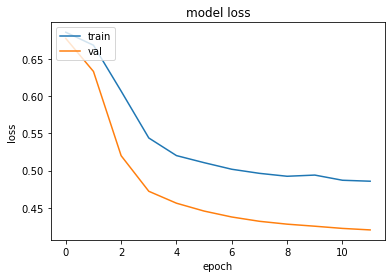

In [50]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

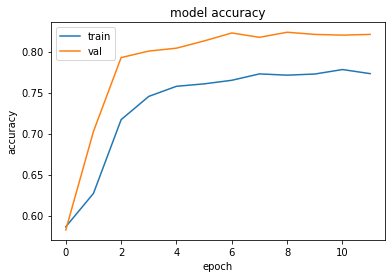

In [49]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
sample_submission = pd.read_csv('../reports/sample_submission.csv')
sample_submission['target'] = model.predict(test_sequences_padded)
sample_submission['target'] = sample_submission['target'].round().astype(int)
sample_submission.to_csv('../reports/glove_submission_v2.csv', index=False)